In [1]:
import numpy as np 
import pandas as pd 
from tensorflow import keras 
from tensorflow.keras import layers

2024-08-13 10:33:59.201516: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-13 10:33:59.201645: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-13 10:33:59.344573: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = (boston_housing.load_data())

57026/57026 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step


In [3]:
train_data.shape

(404, 13)

In [4]:
# Нормализация данных
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

In [5]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [6]:
# Проверка по К блокам
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print(f'Processing fold №{i}')
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=16, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

Processing fold №0
Processing fold №1
Processing fold №2
Processing fold №3


In [7]:
all_scores

[2.0061309337615967, 2.48610520362854, 2.574408769607544, 2.3127706050872803]

In [8]:
np.mean(all_scores)

2.3448538780212402

In [10]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print(f'Processing fold №{i}')
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=16, verbose=0, validation_data=(val_data, val_targets))
    
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

Processing fold №0
Processing fold №1
Processing fold №2
Processing fold №3


In [11]:
avrg_mae = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

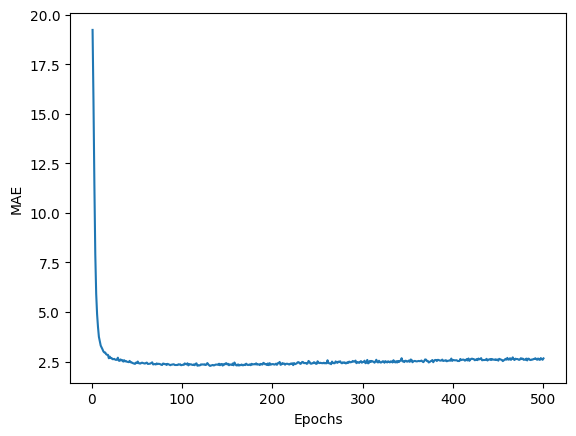

In [12]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(avrg_mae) + 1), avrg_mae)
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.show()

Первые эпохи содержат большой разрыв в показаниях, исключим их

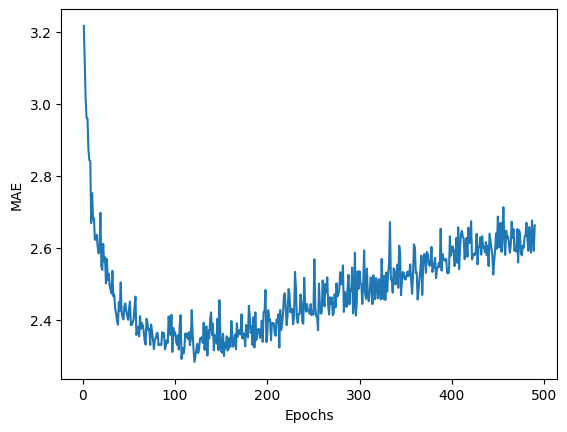

In [13]:
new_avg = avrg_mae[10:]
plt.plot(range(1, len(new_avg) + 1), new_avg)
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.show()

In [14]:
model = build_model()
model.fit(train_data, train_targets, epochs=130, batch_size=16, verbose=0)
test_mse, test_mae = model.evaluate(test_data, test_targets)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.9581 - mae: 2.2613 


In [15]:
test_mae

2.454190969467163